# Import Files

In [8]:
import math
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display as lbd
import tensorflow as tf
import os
import pathlib
from keras.utils import to_categorical
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Import Dataset

In [9]:
audio_dataset = []
audio_dataset_list = []
if os.path.isdir("audio"):
    # Create a list of all audio files for tensorflow
    audio_dataset_list = os.listdir(path='audio/')
    audio_dataset = tf.io.gfile.glob("audio" + '/*')
else:
    exit("No audio dataset folder found")
    print("No audio dataset folder found")

# Split Dataset

In [10]:
seed = 24
training_percent = .80
validation_percent = 1-training_percent
# split dataset into male and female
audio_male = []
audio_female = []
for names in audio_dataset_list:
    if names[1] == 'M':
        audio_male.append(names)
    elif names[1] == 'F':
        audio_female.append(names)

# Take a percentage of the male and female dataset for training and validation
# Makes sure that there's an equal number of males and females in training and validation
audio_male_shuffled = tf.random.shuffle(audio_male)
audio_female_shuffled = tf.random.shuffle(audio_female)
training_unshuffled = tf.concat([audio_male_shuffled[:int(training_percent*160)], audio_female_shuffled[:int(training_percent*160)]], 0)
training = tf.random.shuffle(training_unshuffled)
validation = tf.concat([audio_male_shuffled[math.floor(-validation_percent*160):], audio_female_shuffled[math.floor(-validation_percent*160):]], 0)
print("Training length: " + str(len(training)))
print("Validation length: " + str(len(validation)))

Training length: 256
Validation length: 64


# Function Definitions

In [11]:
def wav2mfcc(file_path, max_pad):

    wave, sample_rate = lb.core.load(file_path)
    mfcc = lb.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=20)
    pad_width = max_pad - mfcc.shape[1]

    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:,0:max_pad]

    return mfcc

def wav2pitch(file_path, max_pad1, max_pad2):

    wave, sample_rate = lb.core.load(file_path)
    pitch, mag = lb.core.piptrack(y=wave, sr=sample_rate, n_fft=512)

    if pitch.shape[0] < max_pad1:
        pad_width = max_pad1 - pitch.shape[0]
        pitch = np.pad(pitch, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        pitch = pitch[0:max_pad1]

    if pitch.shape[1] < max_pad2:
        pad_width = max_pad2 - pitch.shape[1]
        pitch = np.pad(pitch, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return pitch

def print_stats(y_test, pred):
    CM = confusion_matrix(y_test,pred)
    TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()

    Accuracy = accuracy_score(y_test,pred)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)

    print('==='*20)
    print('Accuracy = '+str(Accuracy))
    print('==='*20)
    print('Precision = '+str(Precision))
    print('==='*20)
    print('Recall = '+str(Recall))
    print('==='*20)
    print('F1 = '+str(F1))
    print('==='*20)

    return CM



# Audio Processing

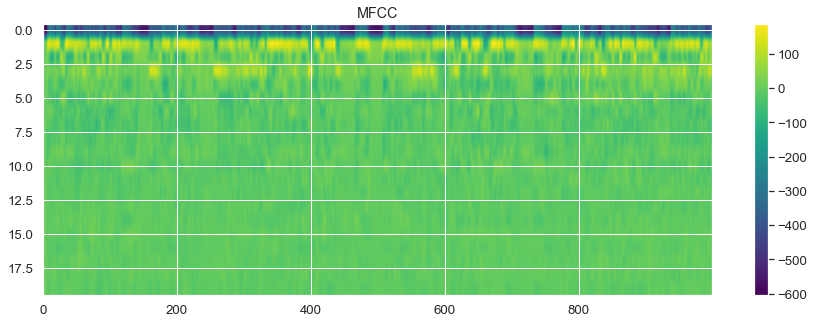

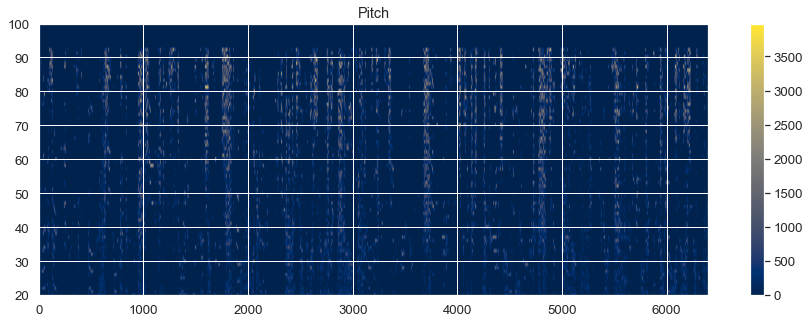

In [28]:
# MFCC Feature Extraction
if not os.path.isfile('mfccs_all_samples.npy'):

    mfcc_list = []

    # Extract MFCC feature from each audio file and save to a list
    for audio_path in audio_dataset:
        mfcc_list.append(wav2mfcc(audio_path, 1000))
        # print(audio_path)


    plt.imshow(mfcc_list[0], aspect='auto', cmap=cm.viridis)
    plt.show()

    # Save list to file so feature extraction isn't needed on same dataset
    mfccs = np.asarray(mfcc_list)
    np.save('mfccs_all_samples.npy', mfccs)

else:
    mfccs_loaded = np.load('mfccs_all_samples.npy')

    plt.figure(figsize=(15,5))
    plt.imshow(mfccs_loaded[0], aspect='auto', cmap=cm.viridis)
    plt.colorbar()
    plt.title('MFCC')



# Pitch Contour Extraction
if not os.path.isfile('pitch_all_samples.npy'):

    pitch_list = []

    # Extract Pitch feature from each audio file and save to a list

    for audio_path in audio_dataset:
        pitch_list.append(wav2pitch(audio_path, 100, 10000))
        # print(audio_path)

    plt.figure(figsize=(15,5))
    plt.imshow(pitch_list[0], aspect='auto', cmap=cm.cividis)
    plt.title('Pitch')
    plt.ylim([20,100])
    plt.xlim([0, 6399])
    plt.colorbar()

    # Save list to file so feature extraction isn't needed on same dataset
    pitch_list = np.asarray(pitch_list)
    np.save('pitch_all_samples.npy', pitch_list)

else:
    pitch_loaded = np.load('pitch_all_samples.npy')

    plt.figure(figsize=(15,5))
    plt.imshow(pitch_loaded[0], aspect='auto', cmap=cm.cividis)
    plt.title('Pitch')
    plt.ylim([20,100])
    plt.xlim([0, 6399])
    plt.colorbar()

# Dictionary Creator

In [13]:
mfccs_loaded = np.load('mfccs_all_samples.npy')
pitch_loaded = np.load('pitch_all_samples.npy')
detail_list = []
cnt = 0

for index, audio_path in enumerate(audio_dataset):
    # if index == 320: # For some reason this is needed only when John runs the code
    #     break
    audio_path = audio_path[6:]
    detail_list.append({'name':audio_path, 'mfcc':mfccs_loaded[index], 'pitch':pitch_loaded[index]})


# Split Data Features

In [14]:
from sklearn import preprocessing

trained_info = []
validation_info = []
mfcc_train = []
mfcc_validation = []
pitch_train = []
pitch_validation = []
name_train = []
name_validation = []
training_outcome = []
validation_outcome = []

# Separate training data (Truths/Lies) into its own list
print(len(training))
for i in range(len(training)):
    wav_name = training[i].numpy().decode('utf-8')
    wav_name_tl = wav_name[8]
    if wav_name_tl == 'T':
        training_outcome.append(1)
    else:
        training_outcome.append(0)
    for cnt in range(len(detail_list)):
        if detail_list[cnt]['name'].find(training[i].numpy().decode('utf-8')) != -1:
            trained_info.append(detail_list[cnt])

# Separate validation data (Truths/Lies) into its own list
for i in range(len(validation)):
    wav_name = validation[i].numpy().decode('utf-8')
    wav_name_tl = wav_name[8]
    if wav_name_tl == 'T':
        validation_outcome.append(1)
    else:
        validation_outcome.append(0)
    for cnt in range(len(detail_list)):
        if detail_list[cnt]['name'].find(validation[i].numpy().decode('utf-8')) != -1:
            validation_info.append(detail_list[cnt])

for cnt in range(len(trained_info)):
    mfcc_train.append(trained_info[cnt]['mfcc'])
    if cnt < len(validation_info):
        mfcc_validation.append(validation_info[cnt]['mfcc'])

for cnt in range(len(trained_info)):
    pitch_train.append(trained_info[cnt]['pitch'])
    if cnt < len(validation_info):
        pitch_validation.append(validation_info[cnt]['pitch'])

for cnt in range(len(trained_info)):
    name_train.append(trained_info[cnt]['name'])
    if cnt < len(validation_info):
        name_validation.append(validation_info[cnt]['name'])

mfcc_train = np.asarray(mfcc_train)
X = mfcc_train
nsamples, nx, ny = X.shape
X_trainMFCC = X.reshape((nsamples, nx*ny))

mfcc_validation = np.asarray(mfcc_validation)
X = mfcc_validation
nsamples, nx, ny = X.shape
X_testMFCC = X.reshape((nsamples, nx*ny))

pitch_train = np.asarray(pitch_train)
X = pitch_train
nsamples, nx, ny = X.shape
X_trainPitch = X.reshape((nsamples, nx*ny))

pitch_validation = np.asarray(pitch_validation)
X = pitch_validation
nsamples, nx, ny = X.shape
X_testPitch = X.reshape((nsamples, nx*ny))
# temp = training_outcome.pop()
y_train = np.asarray(training_outcome)
y_test = np.asarray(validation_outcome)

256


# Classifiers


In [37]:
from sklearn.linear_model import LogisticRegression                    # Regression classifier
from sklearn.tree import DecisionTreeClassifier                        # Decision Tree classifier
from sklearn import svm                                                # Support Vector Machine
from sklearn.linear_model import SGDClassifier                         # Stochastic Gradient Descent Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Random Forest and Gradient Boosting Classifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix # Metrics to check the performance of models

Classifiers = {
    'SVM':svm.SVC(kernel='sigmoid', C=0.1, probability=True),
    'LR':LogisticRegression(random_state=1,C=5,max_iter=200),
    'SGD':SGDClassifier(loss="squared_hinge", penalty="l1", max_iter=2000, shuffle=False),
    'DTC':DecisionTreeClassifier(random_state=10,min_samples_leaf=2,max_features="log2",criterion="entropy"),
    'KNN':KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'),
    'GBC':GradientBoostingClassifier(random_state=10,n_estimators=800,learning_rate=0.2),
}

def ML_PipelineMFCC(clf_name):
    clf = Classifiers[clf_name]
    fit = clf.fit(X_trainMFCC, y_train)
    pred = clf.predict(X_testMFCC)

    np.asarray(pred)
    np.save('MFCC_'+clf_name, pred)

    cmMFCC = print_stats(y_test, pred)

    return cmMFCC

def ML_PipelinePitch(clf_name):
    clf = Classifiers[clf_name]
    fit = clf.fit(X_trainPitch, y_train)
    pred = clf.predict(X_testPitch)

    np.asarray(pred)
    np.save('Pitch_'+clf_name, pred)

    cmPitch = print_stats(y_test, pred)

    return cmPitch

print('==='*20)
print('Decision Tree')
print('==='*20)
cmMFCC_DTC = ML_PipelineMFCC('DTC')

cmPitch_DTC = ML_PipelinePitch('DTC')
print('')
print('==='*20)
print('Support Vector Machine')
print('==='*20)
cmMFCC_SVM = ML_PipelineMFCC('SVM')

cmPitch_SVM = ML_PipelinePitch('SVM')
print('')
print('==='*20)
print('Stochastic Gradient Descent')
print('==='*20)
cmMFCC_SGD = ML_PipelineMFCC('SGD')

cmPitch_SGD = ML_PipelinePitch('SGD')
print('')
print('==='*20)
print('Regression')
print('==='*20)
cmMFCC_LR = ML_PipelineMFCC('LR')

cmPitch_LR = ML_PipelinePitch('LR')
print('')
print('==='*20)
print('K Nearest Neighbor')
print('==='*20)
cmMFCC_KNN = ML_PipelineMFCC('KNN')

cmPitch_KNN = ML_PipelinePitch('KNN')
print('')
print('==='*20)
print('Gradient Boosting Classifier')
print('==='*20)
cmMFCC_GBC = ML_PipelineMFCC('GBC')

cmPitch_GBC = ML_PipelinePitch('GBC')


Decision Tree
Accuracy = 0.421875
Precision = 0.32
Recall = 0.2857142857142857
F1 = 0.30188679245283023
Accuracy = 0.515625
Precision = 0.45714285714285713
Recall = 0.5714285714285714
F1 = 0.5079365079365079

Support Vector Machine
Accuracy = 0.4375
Precision = 0.4375
Recall = 1.0
F1 = 0.6086956521739131
Accuracy = 0.4375
Precision = 0.4375
Recall = 1.0
F1 = 0.6086956521739131

Stochastic Gradient Descent
Accuracy = 0.5
Precision = 0.4
Recall = 0.2857142857142857
F1 = 0.3333333333333333
Accuracy = 0.546875
Precision = 0.48717948717948717
Recall = 0.6785714285714286
F1 = 0.5671641791044776

Regression
Accuracy = 0.46875
Precision = 0.4117647058823529
Recall = 0.5
F1 = 0.45161290322580644
Accuracy = 0.4375
Precision = 0.4375
Recall = 1.0
F1 = 0.6086956521739131

K Nearest Neighbor
Accuracy = 0.46875
Precision = 0.40625
Recall = 0.4642857142857143
F1 = 0.4333333333333333
Accuracy = 0.5625
Precision = nan
Recall = 0.0
F1 = nan

Gradient Boosting Classifier
Accuracy = 0.578125
Precision = 0

<ipython-input-11-3b15b924ac29>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = TP / (TP + FP)


# Ensemble Learning

In [77]:
# Load features for ensemble learning and concatenate predictions from all classifiers

# LRM = np.load('MFCC_LR.npy').tolist()
LRP = np.load('Pitch_LR.npy').tolist()
# DTC = np.load('DTC.npy').tolist()
GBCM = np.load('MFCC_GBC.npy').tolist()
GBCP = np.load('Pitch_GBC.npy').tolist()
# SGDM = np.load('MFCC_SGD.npy').tolist()
SGDP = np.load('Pitch_SGD.npy').tolist()
# SVMM = np.load('MFCC_SVM.npy').tolist()
# SVMP = np.load('Pitch_SVM.npy').tolist()
# KNNM = np.load('MFCC_KNN.npy').tolist()
KNNP = np.load('Pitch_KNN.npy').tolist()

arr = np.array((GBCM,GBCP,SGDP,KNNP))

combined_features = arr.T
print(combined_features)
print(combined_features.shape[0])

majority_pred = [-1] * combined_features.shape[0]
numtruth = 0
numlies = 0

for i in range(0,combined_features.shape[0]):
  numtruth = 0
  numlies = 0

  for j in range(0,3):
    if (combined_features[i][j] == 0):
      numtruth = numtruth + 1
    else:
      numlies = numlies + 1

  if (numtruth > numlies):
    majority_pred[i] = 0
  else:
    majority_pred[i] = 1

print(majority_pred)

print_stats(y_test,majority_pred)


[[0 1 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 1 1 0]
 [1 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 0 0 0]
 [0 1 1 0]
 [1 0 1 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 1 1 0]
 [1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 1 1 0]
 [1 0 0 0]]
64
[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0]
Accuracy = 0.59375
Precision = 0.5416666666666666
Recall = 0.4642857142857143
F1 = 0.5


array([[25, 11],
       [15, 13]], dtype=int64)

# Plotting

AUC:  0.5515873015873016


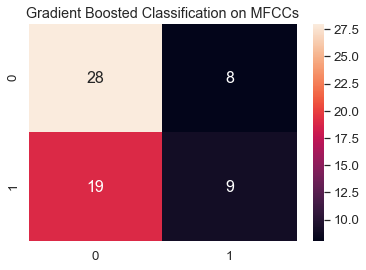

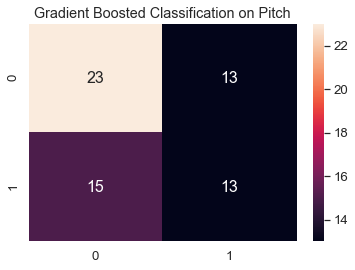

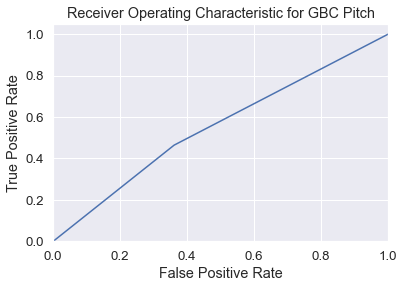

In [81]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cmMFCC_GBC, range(2), range(2))
plt.figure(figsize=(6,4))
plt.title("Gradient Boosted Classification on MFCCs")
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

df_cm = pd.DataFrame(cmPitch_GBC, range(2), range(2))
plt.figure(figsize=(6,4))
plt.title("Gradient Boosted Classification on Pitch")
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

decision_arr = np.array((GBCM,GBCP))
decision_arr = np.transpose(decision_arr)
df_gm = pd.DataFrame(decision_arr, range(64), range(2))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), GBCP)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("AUC: ", roc_auc_score(y_test.ravel(), GBCP))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for GBC Pitch')
plt.show()